# Cat vs. Dog Image Classification

1. Download data and set paths
2. Data Augmentation and modelling
3. Train Model
4. Evaluate model
5. Write into submission.csv
6. Train and evaluate CIFAR-10 Dataset

Let's go!

In [ ]:
!nvidia-smi

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
save_checkpoint_dir = "drive/MyDrive/aiproject"

# Part 1 - Download data and set paths

Let's download datasets from the link provided!

In [3]:
!gdown https://drive.google.com/uc?id=1q0r6yeHQMS17R3wz-s2FIbMR5DAGZK5v -O /tmp/cats_dogs_filtered.zip

Downloading...
From: https://drive.google.com/uc?id=1q0r6yeHQMS17R3wz-s2FIbMR5DAGZK5v
To: /tmp/cats_dogs_filtered.zip
100% 1.10G/1.10G [00:06<00:00, 175MB/s]


Unzipping it and save to /tmp

In [4]:
import os
import zipfile

local_zip = '/tmp/cats_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

creating path for easier for easier execution


In [5]:
base_dir = '/tmp/datasets'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir,'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cat')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dog')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')


Reading images

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.7411.jpg', 'cat.9088.jpg', 'cat.1641.jpg', 'cat.10811.jpg', 'cat.11034.jpg', 'cat.8823.jpg', 'cat.1565.jpg', 'cat.9362.jpg', 'cat.8325.jpg', 'cat.2272.jpg']
['dog.0.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.10000.jpg', 'dog.10001.jpg', 'dog.10002.jpg', 'dog.10003.jpg', 'dog.10004.jpg', 'dog.10005.jpg', 'dog.10006.jpg']


Number of images of `train` and `validation` cats and dogs 

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500


Images displayed


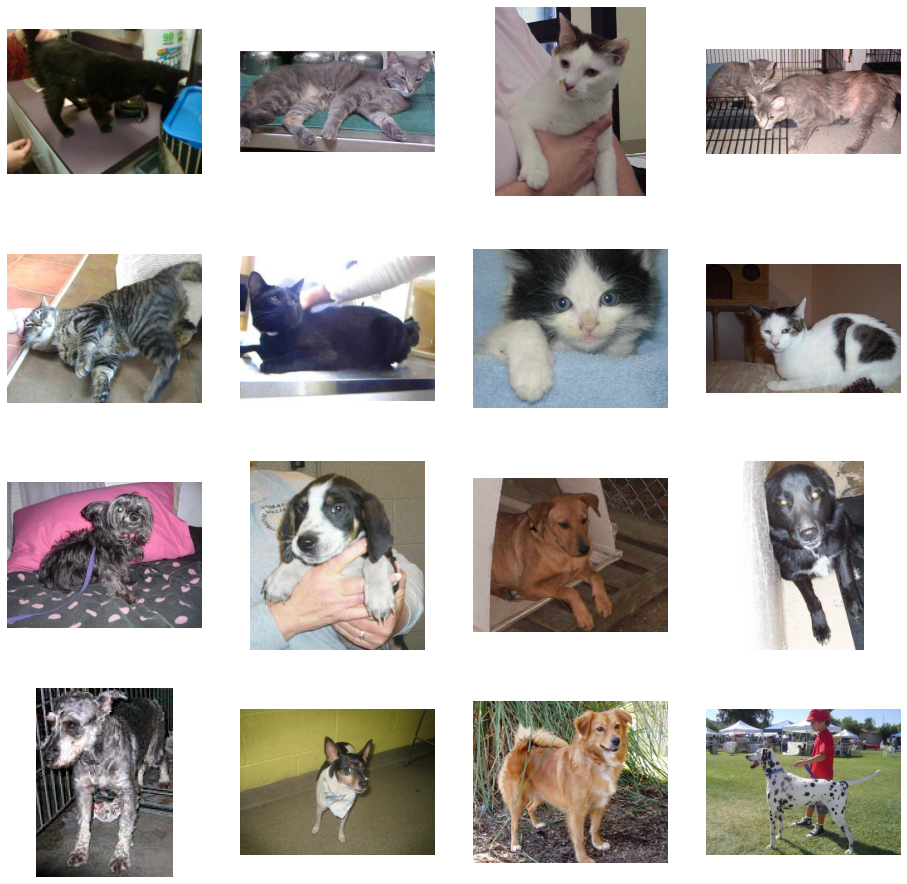

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(16,16)
nrows =4
ncols = 4
pic_index = 0
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Part 2 - *Data Augmentation and modelling*


In [9]:
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import tensorflow as tf

Note that Data augmentation is only use for train set

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255.)


Note that InceptionV3 input is (150,150,3)

In [11]:
# InceptionV3

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 128, class_mode = 'binary', target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(validation_dir,  batch_size = 128, class_mode = 'binary', target_size = (150, 150))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Download InceptionV3 pretrained model and leave the top layer as False so that we can have our own output

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


Keep layers frozen, modify last layer

In [13]:
for layer in base_model.layers:
    layer.trainable = False

Set last layer few layers of output `sigmoid` as activation layer as it pairs up with binary classification problems
Loss function set as `binary_crossentropy` since its a binary classification problem

In [14]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

# Part 3 - Train Model with InceptionV3 with RMSprop optimizer


In [15]:
inc_history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 20)

Epoch 1/20
100/100 [==============================] - 169s 1s/step - loss: 0.6635 - acc: 0.8647 - val_loss: 0.1035 - val_acc: 0.9614
Epoch 2/20
100/100 [==============================] - 130s 1s/step - loss: 0.2392 - acc: 0.9044 - val_loss: 0.1319 - val_acc: 0.9476
Epoch 3/20
100/100 [==============================] - 130s 1s/step - loss: 0.2287 - acc: 0.9070 - val_loss: 0.0926 - val_acc: 0.9654
Epoch 4/20
100/100 [==============================] - 129s 1s/step - loss: 0.2137 - acc: 0.9157 - val_loss: 0.1155 - val_acc: 0.9578
Epoch 5/20
100/100 [==============================] - 125s 1s/step - loss: 0.2122 - acc: 0.9172 - val_loss: 0.1267 - val_acc: 0.9562
Epoch 6/20
100/100 [==============================] - 125s 1s/step - loss: 0.1992 - acc: 0.9243 - val_loss: 0.0909 - val_acc: 0.9644
Epoch 7/20
100/100 [==============================] - 124s 1s/step - loss: 0.1917 - acc: 0.9278 - val_loss: 0.1193 - val_acc: 0.9528
Epoch 8/20
100/100 [==============================] - 129s 1s/step - 

Train your model! Remember to add in checkpoints to save your model!

In [16]:
checkpoint_filepath = '/drive/MyDrive/aiproject'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

batch_size=128




In [17]:
model.save('drive/MyDrive/aiproject/inceptionv3_model_lr0001.h5')
#model.load('drive/MyDrive/aiproject/my_model.h5')

# Part 4 - Evaluate model

Text(0.5, 1.0, 'Training and validation loss')

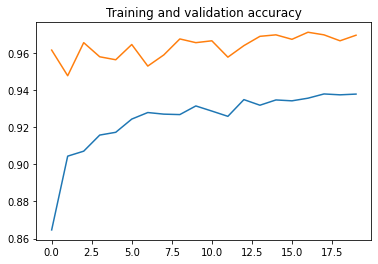

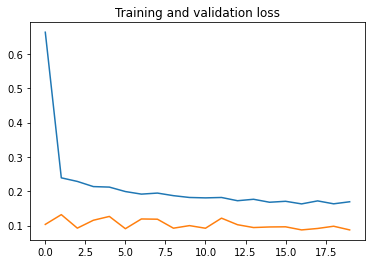

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = inc_history.history['acc']
val_acc = inc_history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Predict with your model!

In [19]:
# Input image filepath and convert it to numpy array for model to predict
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [20]:
# Testing your image with VGG model
# Cat: 0 , Dog: 1
test_files = os.listdir(test_dir)
image = load(os.path.join(test_dir,test_files[1])) 

# image 490.jpg is a cat hence output should be 0, try others to test
print(os.path.join(test_dir,test_files[1]))



/tmp/datasets/test/208.jpg


In [24]:
model.predict(image)

array([[0.8731462]], dtype=float32)

In [25]:
print(model.predict(image)[0][0])

0.8731462


# Part 5 - Predict test images and parse into submission.csv

In [26]:
import pandas as pd
import os

In [27]:
test_files = os.listdir(test_dir)
testname = []
labels = []
for i in range (1,len(test_files)+1):
  filename = test_dir + "/"+ str(i) + ".jpg"
  image = load(filename)

  if model.predict(image)[0][0] < 0.5:
    labels.append(0)
  else:
    labels.append(1)
  testname.append(str(i))

dataframe = pd.DataFrame({"id": testname, "labels": labels}, columns = ["id","labels"])
dataframe.sort_values(by=['id'], ascending=True)
dataframe.to_csv("drive/MyDrive/aiproject/submissions1.csv", index = False)


# Part 6 - CIFAR-10 Datasets
Load CIFAR-10 Datasets

In [28]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Tensorflow version 2.7.0


In [29]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

170508288/170498071 [==============================] - 2s 0us/step


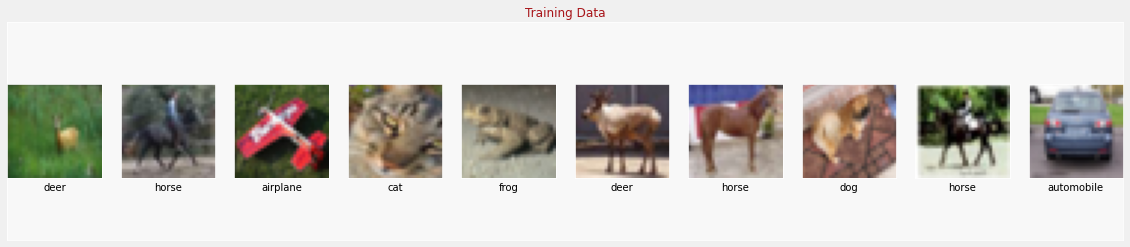

In [30]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()
display_images(training_images, training_labels, training_labels, "Training Data" )

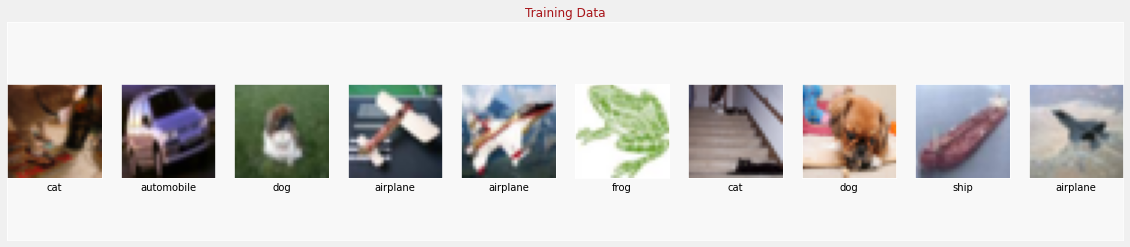

In [31]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [32]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.inception_v3.preprocess_input(input_images)
  return output_ims

In [33]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [34]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [35]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/3
782/782 [==============================] - 853s 1s/step - loss: 0.4780 - accuracy: 0.8503 - val_loss: 0.2193 - val_accuracy: 0.9300
Epoch 2/3
782/782 [==============================] - 833s 1s/step - loss: 0.1323 - accuracy: 0.9567 - val_loss: 0.1640 - val_accuracy: 0.9450
Epoch 3/3
782/782 [==============================] - 833s 1s/step - loss: 0.0575 - accuracy: 0.9821 - val_loss: 0.1707 - val_accuracy: 0.9495


In [36]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 45s 286ms/step - loss: 0.1707 - accuracy: 0.9495


In [39]:
model.save('drive/MyDrive/aiproject/my_model_cifar10.h5')

# Clean Up

Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)